<a href="https://colab.research.google.com/github/faiyaz106/Text_Classification_using_RNN/blob/main/NLP_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Text classification using Neural Networks

The goal of this notebook is to learn to use Neural Networks for text classification.

In this notebook, we will:

Train a shallow model with learning embeddings

Download pre-trained embeddings from Glove

Use these pre-trained embeddings

However keep in mind:

Deep Learning can be better on text classification that simpler ML techniques, but only on very large datasets and well designed/tuned models.
We won't be using the most efficient (in terms of computing) techniques, as Keras is good for prototyping but rather inefficient for training small embedding models on text.

The following projects can replicate similar word embedding models much more efficiently: word2vec (https://github.com/dav/word2vec) and gensim's word2vec (https://radimrehurek.com/gensim/models/word2vec.html) (self-supervised learning only), fastText (https://github.com/facebookresearch/fastText)(both supervised and self-supervised learning), Vowpal Wabbit (https://github.com/VowpalWabbit/vowpal_wabbit/wiki)(supervised learning).
Plain shallow sparse TF-IDF bigrams features without any embedding and Logistic Regression or Multinomial Naive Bayes is often competitive in small to medium datasets.

20 Newsgroups Dataset

The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups http://qwone.com/~jason/20Newsgroups/ 

In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

In [2]:
sample_idx = 1000
print(newsgroups_train["data"][sample_idx])

From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)
Subject: Diamond SS24X, Win 3.1, Mouse cursor
Organization: National Library of Medicine
Lines: 10


Anybody seen mouse cursor distortion running the Diamond 1024x768x256 driver?
Sorry, don't know the version of the driver (no indication in the menus) but it's a recently
delivered Gateway system.  Am going to try the latest drivers from Diamond BBS but wondered
if anyone else had seen this.

post or email

--Don Lindbergh
dabl2@lhc.nlm.nih.gov



In [41]:
target_names = newsgroups_train["target_names"]
target_id = newsgroups_train["target"][sample_idx]
print("Class of previous message:", target_names[target_id])

Class of previous message: comp.os.ms-windows.misc


Here are all the possible classes:

2

Preprocessing text for the (supervised) CBOW model

We will implement a simple classification model in Keras. Raw text requires (sometimes a lot of) preprocessing.

The following cells uses Keras to preprocess text:

using a tokenizer. You may use different tokenizers (from scikit-learn, NLTK, custom Python function etc.). This converts the texts into sequences of indices representing the 20000 most frequent words

sequences have different lengths, so we pad them (add 0s at the end until the sequence is of length 1000)

we convert the output classes as 1-hot encodings

In [7]:
from keras.preprocessing.text import Tokenizer
MAX_NB_WORDS = 20000
# get the raw text data
texts_train = newsgroups_train["data"]
texts_test = newsgroups_test["data"]

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 134142 unique tokens.


In [23]:
word_index['hello']

1718

In [ ]:
len(sequences[685])

324

Tokenized sequences are converted to list of token ids (with an integer code):



In [ ]:
sequences[0]


[14,
 4308,
 1350,
 15,
 11126,
 38,
 250,
 29,
 42,
 298,
 9,
 17,
 95,
 78,
 91,
 4308,
 1350,
 15,
 34,
 77,
 3,
 2952,
 610,
 1767,
 32,
 211,
 8,
 26,
 1308,
 27,
 171,
 66,
 47,
 123,
 9879,
 63,
 16,
 17,
 298,
 8,
 708,
 1,
 86,
 263,
 11,
 26,
 4,
 36,
 1497,
 2266,
 298,
 1162,
 2,
 18,
 14,
 1,
 1347,
 13637,
 843,
 15448,
 11,
 26,
 337,
 4,
 1,
 4017,
 80,
 182,
 484,
 7,
 1376,
 1,
 844,
 8164,
 26,
 1835,
 14,
 1,
 816,
 3,
 1,
 726,
 17,
 9,
 44,
 8,
 88,
 27,
 171,
 39,
 4,
 828,
 273,
 1078,
 2908,
 198,
 3,
 2804,
 153,
 17,
 298,
 9,
 239,
 628,
 25,
 808,
 357,
 13,
 21,
 16,
 17,
 384,
 298,
 181,
 112,
 188,
 206,
 1498,
 1341,
 2,
 13,
 35,
 58,
 7860]

The tokenizer object stores a mapping (vocabulary) from word strings to token ids that can be inverted to reconstruct the original message (without formatting):

In [24]:
type(tokenizer.word_index), len(tokenizer.word_index)

(dict, 134142)

In [25]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())

In [ ]:
" ".join([index_to_word[i] for i in sequences[0]])

"from wam umd edu where's my thing subject what car is this nntp posting host wam umd edu organization university of maryland college park lines 15 i was wondering if anyone out there could enlighten me on this car i saw the other day it was a 2 door sports car looked to be from the late 60s early 70s it was called a the doors were really small in addition the front bumper was separate from the rest of the body this is all i know if anyone can a model name engine specs years of production where this car is made history or whatever info you have on this looking car please e mail thanks il brought to you by your neighborhood"

Let's have a closer look at the tokenized sequences:

In [27]:
seq_lens = [len(s) for s in sequences]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

average length: 302.5
max length: 15365


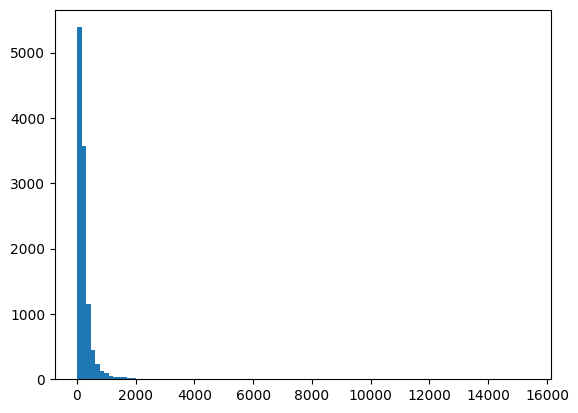

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(seq_lens, bins=100);

Let's zoom on the distribution of regular sized posts. The vast majority of the posts have less than 3000 symbols:

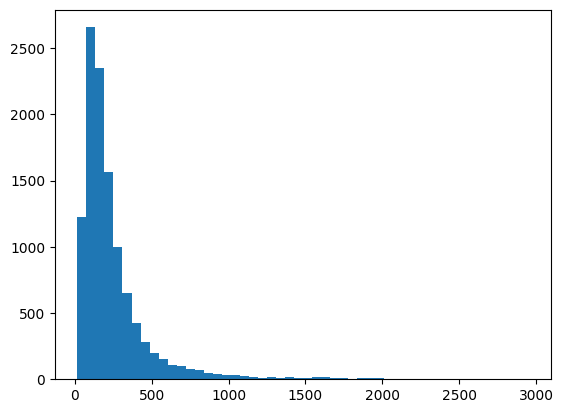

In [31]:
plt.hist([l for l in seq_lens if l < 3000], bins=50);

Let's truncate and pad all the sequences to 1000 symbols to build the training set:

In [32]:
#from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences


MAX_SEQUENCE_LENGTH = 1000

# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

Shape of data tensor: (11314, 1000)
Shape of data test tensor: (7532, 1000)


In [33]:
from keras.utils.np_utils import to_categorical
y_train = newsgroups_train["target"]
y_test = newsgroups_test["target"]
y_train = to_categorical(np.asarray(y_train))
print('Shape of label tensor:', y_train.shape)

Shape of label tensor: (11314, 20)


In [36]:
newsgroups_train["target"]

array([7, 4, 4, ..., 3, 1, 8])

A simple supervised Bag of Words model in Keras

The following computes a very simple model, as described in fastText https://github.com/facebookresearch/fastText :

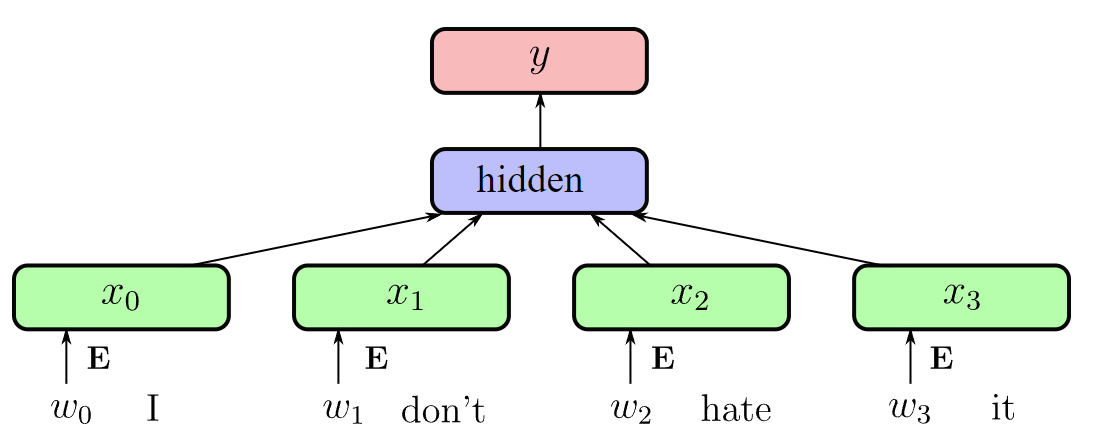

Build an embedding layer mapping each word to a vector representation

Compute the vector representation of all words in each sequence and average them

Add a dense layer to output 20 classes (+ softmax)

In [ ]:
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model

EMBEDDING_DIM = 50
N_CLASSES = len(target_names)
# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
model.fit(x_train, y_train, validation_split=0.1,epochs=50, batch_size=128)

Epoch 1/50
80/80 [==============================] - 17s 165ms/step - loss: 2.9864 - acc: 0.0765 - val_loss: 2.9774 - val_acc: 0.1157
Epoch 2/50
80/80 [==============================] - 13s 159ms/step - loss: 2.9620 - acc: 0.1264 - val_loss: 2.9510 - val_acc: 0.1555
Epoch 3/50
80/80 [==============================] - 12s 149ms/step - loss: 2.9275 - acc: 0.1697 - val_loss: 2.9128 - val_acc: 0.1793
Epoch 4/50
80/80 [==============================] - 14s 175ms/step - loss: 2.8858 - acc: 0.1990 - val_loss: 2.8704 - val_acc: 0.2297
Epoch 5/50
80/80 [==============================] - 9s 120ms/step - loss: 2.8426 - acc: 0.2268 - val_loss: 2.8293 - val_acc: 0.2376
Epoch 6/50
80/80 [==============================] - 9s 116ms/step - loss: 2.7966 - acc: 0.2702 - val_loss: 2.7834 - val_acc: 0.2641
Epoch 7/50
80/80 [==============================] - 7s 86ms/step - loss: 2.7450 - acc: 0.3250 - val_loss: 2.7301 - val_acc: 0.3269
Epoch 8/50
80/80 [==============================] - 8s 95ms/step - loss: 

In [ ]:
output_test = model(x_test)
test_casses = np.argmax(output_test, axis=-1)
print("Test accuracy:", np.mean(test_casses == y_test))

Test accuracy: 0.7938130642591609


Building more complex models

Recurrent neural networks through LSTM (you will need to reduce sequence length before)

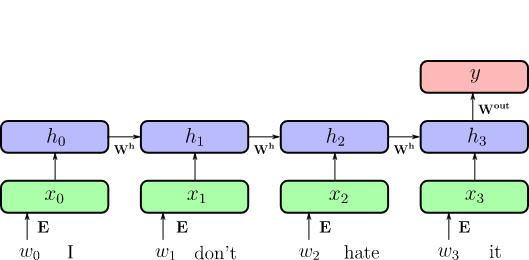



You may try different architectures with:

more intermediate layers, combination of dense, conv, recurrent

different recurrent (GRU, RNN)

bidirectional LSTMs

The goal is to build working models rather than getting better test accuracy. To achieve much better results, we'd need more computation time and data quantity. Build your model, and verify that they converge to OK results.

In [ ]:

from keras.layers import GRU, LSTM, Conv1D, MaxPooling1D

# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

# 1D convolution with 64 output channels
x = Conv1D(64, 5)(embedded_sequences)
# MaxPool divides the length of the sequence by 5
x = MaxPooling1D(5)(x)
x = Conv1D(64, 5)(x)
x = MaxPooling1D(5)(x)
# GRU layer with a hidden size of 64
x = GRU(64)(x)
predictions = Dense(20, activation='softmax')(x)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

# You will get large speedups with these models by using a GPU
# The model might take a lot of time to converge, and even more
# if you add dropout (needed to prevent overfitting)

In [ ]:
model.fit(x_train, y_train, validation_split=0.1, epochs=40, batch_size=128, verbose=2)

Epoch 1/20
80/80 - 14s - loss: 1.4244 - acc: 0.6401 - val_loss: 0.8197 - val_acc: 0.7942 - 14s/epoch - 174ms/step
Epoch 2/20
80/80 - 9s - loss: 0.3784 - acc: 0.9149 - val_loss: 0.5140 - val_acc: 0.8542 - 9s/epoch - 106ms/step
Epoch 3/20
80/80 - 9s - loss: 0.1940 - acc: 0.9534 - val_loss: 0.4288 - val_acc: 0.8746 - 9s/epoch - 116ms/step
Epoch 4/20
80/80 - 8s - loss: 0.1285 - acc: 0.9691 - val_loss: 0.4218 - val_acc: 0.8737 - 8s/epoch - 97ms/step
Epoch 5/20
80/80 - 7s - loss: 0.0893 - acc: 0.9795 - val_loss: 0.4196 - val_acc: 0.8746 - 7s/epoch - 89ms/step
Epoch 6/20
80/80 - 7s - loss: 0.0656 - acc: 0.9872 - val_loss: 0.3854 - val_acc: 0.8825 - 7s/epoch - 89ms/step
Epoch 7/20
80/80 - 6s - loss: 0.0428 - acc: 0.9934 - val_loss: 0.3871 - val_acc: 0.8913 - 6s/epoch - 79ms/step
Epoch 8/20
80/80 - 6s - loss: 0.0316 - acc: 0.9956 - val_loss: 0.4034 - val_acc: 0.8887 - 6s/epoch - 75ms/step
Epoch 9/20
80/80 - 5s - loss: 0.0231 - acc: 0.9977 - val_loss: 0.3884 - val_acc: 0.8958 - 5s/epoch - 63ms/s

In [ ]:
output_test = model(x_test)
test_casses = np.argmax(output_test, axis=-1)
print("Test accuracy:", np.mean(test_casses == y_test))

Test accuracy: 0.82129580456718


In [ ]:

from keras.layers import Conv1D, MaxPooling1D, Flatten

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

# A 1D convolution with 128 output channels
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
# MaxPool divides the length of the sequence by 5
x = MaxPooling1D(5)(x)
# A 1D convolution with 64 output channels
x = Conv1D(64, 5, activation='relu')(x)
# MaxPool divides the length of the sequence by 5
x = MaxPooling1D(5)(x)
x = Flatten()(x)

predictions = Dense(20, activation='softmax')(x)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
model.fit(x_train, y_train, validation_split=0.1, epochs=2, batch_size=128, verbose=2)

Epoch 1/2
80/80 - 56s - loss: 2.1258 - acc: 0.3525 - val_loss: 1.4056 - val_acc: 0.5557 - 56s/epoch - 700ms/step
Epoch 2/2
80/80 - 52s - loss: 0.8367 - acc: 0.7617 - val_loss: 0.9128 - val_acc: 0.7014 - 52s/epoch - 654ms/step


In [ ]:
output_test = model(x_test)
test_casses = np.argmax(output_test, axis=-1)
print("Test accuracy:", np.mean(test_casses == y_test))

Test accuracy: 0.6363515666489644


Loading pre-trained embeddings

The file glove100K.100d.txt is an extract of Glove Vectors (https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip), that were trained on english Wikipedia 2014 + Gigaword 5 (6B tokens).

We extracted the 100 000 most frequent words. They have a dimension of 100

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving glove.6B.100d (1).txt to glove.6B.100d (1).txt


In [ ]:
!ls


'glove.6B.100d (1).txt'   sample_data


In [ ]:
embeddings_index = {}
embeddings_vectors = []
f = open('/content/glove.6B.100d (1).txt','rb')

word_idx = 1
for line in f:
    values = line.decode('utf-8').split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = word_idx
    embeddings_vectors.append(vector)
    word_idx = word_idx + 1
f.close()

inv_index = {v: k for k, v in embeddings_index.items()}
print("found %d different words in the file" % word_idx)

found 400001 different words in the file


In [ ]:
# Stack all embeddings in a large numpy array
glove_embeddings = np.vstack(embeddings_vectors)
glove_norms = np.linalg.norm(glove_embeddings, axis=-1, keepdims=True)
glove_embeddings_normed = glove_embeddings / glove_norms
print(glove_embeddings.shape)

(400000, 100)


In [ ]:
def get_emb(word):
    idx = embeddings_index.get(word)
    if idx is None:
        return None
    else:
        return glove_embeddings[idx]

    
def get_normed_emb(word):
    idx = embeddings_index.get(word)
    if idx is None:
        return None
    else:
        return glove_embeddings_normed[idx]

In [ ]:
get_emb("computer")

array([ 3.4294e-01, -2.4806e-01, -2.1903e-01, -2.7343e-01,  4.1209e-01,
        1.2106e-03,  8.9447e-01,  1.5980e-01, -6.6800e-01, -2.1646e-01,
        9.4019e-01, -3.4529e-01, -1.9443e-01,  5.8047e-02,  8.7329e-01,
        1.5896e-02,  9.1921e-02,  3.5554e-01, -9.9768e-01,  6.9761e-01,
        6.7753e-01, -1.2722e-01,  6.5938e-01,  7.1955e-01,  6.2019e-02,
       -3.5024e-01,  2.3467e-01, -3.4278e-02,  5.8109e-01,  1.6219e-01,
        1.4753e-01,  3.0023e-01,  3.1600e-01, -6.1805e-01, -6.2727e-01,
       -6.6628e-02,  1.6324e-01,  1.1423e-01, -5.2143e-01,  5.7920e-01,
       -2.7500e-02, -6.2960e-01,  8.0471e-01, -3.6092e-01,  3.2068e-01,
       -5.9124e-01, -4.2370e-01, -8.2406e-01, -1.5164e-01, -1.3551e-01,
       -4.2008e-01, -7.1731e-01, -2.7170e-01,  6.7747e-01, -6.5305e-01,
       -2.1724e+00, -4.6184e-01, -7.5181e-01,  1.5218e+00,  8.7949e-01,
       -6.8901e-01,  4.7929e-01, -7.4755e-01,  5.7336e-02, -8.9979e-02,
        6.2477e-01, -4.2093e-01,  2.8386e-01, -7.7733e-03,  5.35

Using pre-trained embeddings in our model

We want to use these pre-trained embeddings for transfer learning. This process is rather similar than transfer learning in image recognition: the features learnt on words might help us bootstrap the learning process, and increase performance if we don't have enough training data.

We initialize embedding matrix from the model with Glove embeddings:

take all words from our 20 Newgroup vocabulary (MAX_NB_WORDS = 20000), and look up their Glove embedding

place the Glove embedding at the corresponding index in the matrix

if the word is not in the Glove vocabulary, we only place zeros in the matrix
We may fix these embeddings or fine-tune them

In [ ]:
EMBEDDING_DIM = 100

# prepare embedding matrix
nb_words_in_matrix = 0
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = get_emb(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        nb_words_in_matrix = nb_words_in_matrix + 1
        
print("added %d words in the embedding matrix" % nb_words_in_matrix)

added 17401 words in the embedding matrix


Build a layer with pre-trained embeddings:

In [ ]:
pretrained_embedding_layer = Embedding(
    MAX_NB_WORDS, EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
)

A model with pre-trained Embeddings

Average word embeddings pre-trained with Glove / Word2Vec usually works surprisingly well. However, when averaging more than 10-15 words, the resulting vector becomes too noisy and classification performance is degraded.

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = pretrained_embedding_layer(sequence_input)
average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)

# We don't want to fine-tune embeddings
model.layers[1].trainable = False

model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['acc'])

In [ ]:
model.fit(x_train, y_train, validation_split=0.1,
          epochs=15, batch_size=32)

Epoch 1/15
319/319 [==============================] - 4s 11ms/step - loss: 2.9768 - acc: 0.0568 - val_loss: 2.9604 - val_acc: 0.0574
Epoch 2/15
319/319 [==============================] - 3s 9ms/step - loss: 2.9543 - acc: 0.0676 - val_loss: 2.9449 - val_acc: 0.0804
Epoch 3/15
319/319 [==============================] - 3s 9ms/step - loss: 2.9420 - acc: 0.0856 - val_loss: 2.9361 - val_acc: 0.0875
Epoch 4/15
319/319 [==============================] - 4s 12ms/step - loss: 2.9317 - acc: 0.1095 - val_loss: 2.9262 - val_acc: 0.1051
Epoch 5/15
319/319 [==============================] - 3s 10ms/step - loss: 2.9230 - acc: 0.1126 - val_loss: 2.9216 - val_acc: 0.1042
Epoch 6/15
319/319 [==============================] - 3s 9ms/step - loss: 2.9161 - acc: 0.1143 - val_loss: 2.9115 - val_acc: 0.1095
Epoch 7/15
319/319 [==============================] - 3s 9ms/step - loss: 2.9094 - acc: 0.1212 - val_loss: 2.9087 - val_acc: 0.1078
Epoch 8/15
319/319 [==============================] - 3s 9ms/step - loss:

In [ ]:
output_test = model(x_test)
test_casses = np.argmax(output_test, axis=-1)
print("Test accuracy:", np.mean(test_casses == y_test))

Test accuracy: 0.15042485395645247


Remarks:

On this type of task, using pre-trained embeddings can degrade results as we train much less parameters and we average a large number pre-trained embeddings.

Pre-trained embeddings followed by global averaging prevents overfitting but can also cause some underfitting.

Using convolutions / LSTM should help counter the underfitting effect.

It is also advisable to treat separately pre-trained embeddings and words out of vocabulary.

Pre-trained embeddings can be very useful when the training set is small and the individual text documents to classify are short: in this case there might be a single very important word in a test document that drives the label. If that word has never been seen in the training set but some synonyms were seen, the semantic similarity captured by the embedding will allow the model to generalized out of the restricted training set vocabulary.

We did not observe this effect here because the document are long enough so that guessing the topic can be done redundantly. Shortening the documents to make the task more difficult could possibly highlight this benefit.